In [1]:
from pathlib import Path
import sys, pathlib, os
Path('../reports/figures').mkdir(parents=True, exist_ok=True)
PROJECT_ROOT = pathlib.Path().resolve().parent
if (PROJECT_ROOT / 'src').exists() and str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))


# Calibration on Synthetic Data
Generate a synthetic option chain, calibrate Heston, and visualize results.


/Users/mahdihoumani/Documents/Quant/Heston_Stochastic_Volatility_calibration/src/models/heston.py:99: RuntimeWarning: Feller condition violated: 2*kappa*theta < sigma^2
  warnings.warn("Feller condition violated: 2*kappa*theta < sigma^2", RuntimeWarning)


Calibrated parameters: kappa=1.4960, theta=0.0400, sigma=0.3999, rho=-0.7001, v0=0.0400
Objective norm: 0.001474
Feller condition satisfied: False
Calibrated: HestonParams(kappa=1.4960098225807696, theta=0.039987661601611886, sigma=0.399917923710775, rho=-0.7000673710636932, v0=0.03998858664923128)


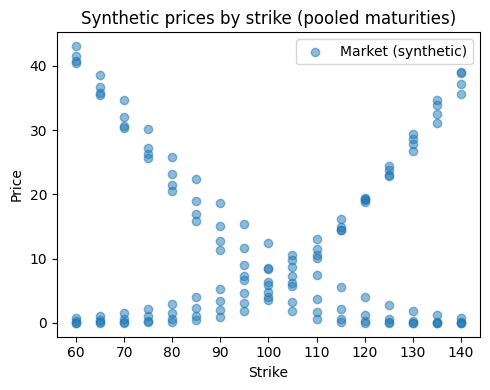

  parameter  true  calibrated
0     kappa  1.50    1.496010
1     theta  0.04    0.039988
2     sigma  0.40    0.399918
3       rho -0.70   -0.700067
4        v0  0.04    0.039989


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.data.option_chain import synthetic_option_chain, default_true_params, default_grid
from src.calibration.calibrate import calibrate
from src.utils.helpers import HestonParams

true_params = default_true_params()
strikes, maturities = default_grid()
market_df = synthetic_option_chain(strikes, maturities, true_params, noise=0.005, seed=42)

result = calibrate(market_df, S0=100.0, r=0.02, q=0.0, target='price', verbose=True)
calibrated = HestonParams(**result['params'])
print('Calibrated:', calibrated)

plt.figure(figsize=(5,4))
plt.scatter(market_df['strike'], market_df['price'], alpha=0.5, label='Market (synthetic)')
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Synthetic prices by strike (pooled maturities)')
plt.legend()
plt.tight_layout()
plt.savefig('../reports/figures/calibration_prices.png', dpi=150)
plt.show()

param_table = pd.DataFrame({'parameter':['kappa','theta','sigma','rho','v0'], 'true':[true_params.kappa,true_params.theta,true_params.sigma,true_params.rho,true_params.v0], 'calibrated':[calibrated.kappa, calibrated.theta, calibrated.sigma, calibrated.rho, calibrated.v0]})
print(param_table)
param_table.to_csv('../reports/figures/calibration_params.csv', index=False)


## Results & Plots
Load calibration result, compare to true params, and visualize IV fit.


Loaded calibration result (seed=42, noise=0.005, target=iv, timestamp=2026-01-04T11:16:55.051248Z)
Calibrated params: {'kappa': 1.5145036651154018, 'theta': 0.04039120789100607, 'sigma': 0.45460918406268663, 'rho': -0.6688695973442288, 'v0': 0.03952570024210672}


,Parameter,True,Calibrated,AbsError,RelError
0,kappa,1.50,1.514504,0.014504,0.009669
1,theta,0.04,0.040391,0.000391,0.009780
2,sigma,0.40,0.454609,0.054609,0.136523
3,rho,-0.70,-0.668870,0.031130,-0.044472
4,v0,0.04,0.039526,-0.000474,-0.011857


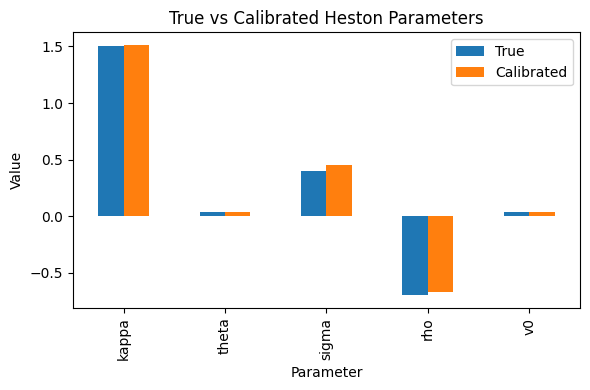

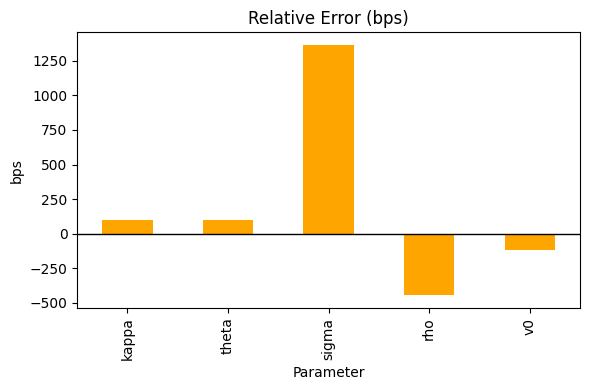

/Users/mahdihoumani/Documents/Quant/Heston_Stochastic_Volatility_calibration/src/models/heston.py:99: RuntimeWarning: Feller condition violated: 2*kappa*theta < sigma^2
  warnings.warn("Feller condition violated: 2*kappa*theta < sigma^2", RuntimeWarning)


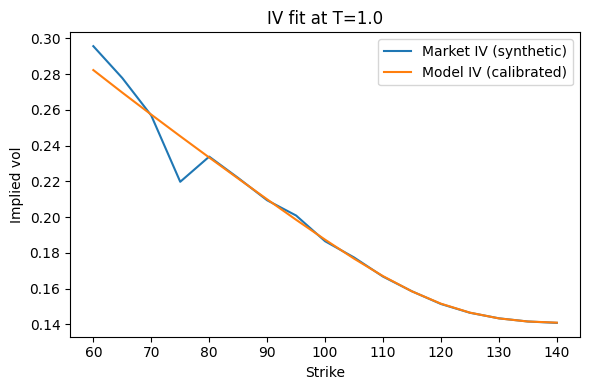

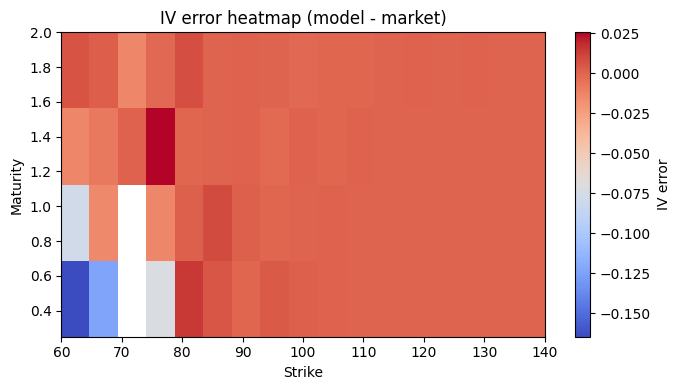

Saved: ../reports/figures/params_true_vs_calibrated.png
Saved: ../reports/figures/params_relative_error_bp.png
Saved: ../reports/figures/iv_fit_T1.png
Saved: ../reports/figures/iv_error_heatmap.png


In [5]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.data.option_chain import default_grid, synthetic_option_chain, default_true_params
from src.models.heston import heston_call_price
from src.models.black_scholes import implied_volatility

# Load calibration JSON
cal_path = Path('../reports/calibration_result.json')
with cal_path.open('r') as f:
    cal_res = json.load(f)
meta = cal_res.get('metadata', {})
cal_params = cal_res['params']
print(f"Loaded calibration result (seed={meta.get('seed')}, noise={meta.get('noise')}, target={meta.get('target')}, timestamp={cal_res.get('timestamp')})")
print('Calibrated params:', cal_params)

# True params
true_params = default_true_params().as_dict()
order = ['kappa','theta','sigma','rho','v0']
df_cmp = pd.DataFrame({
    'Parameter': order,
    'True': [true_params[k] for k in order],
    'Calibrated': [cal_params[k] for k in order]
})
df_cmp['AbsError'] = df_cmp['Calibrated'] - df_cmp['True']
df_cmp['RelError'] = df_cmp['AbsError'] / df_cmp['True']
display(df_cmp)

# Plot 1: True vs Calibrated
df_cmp.set_index('Parameter')[['True','Calibrated']].plot(kind='bar', figsize=(6,4))
plt.title('True vs Calibrated Heston Parameters')
plt.ylabel('Value')
plt.tight_layout()
plt.savefig('../reports/figures/params_true_vs_calibrated.png', dpi=150)
plt.show()
# Plot 2: Relative error in bps
df_cmp['ErrorBP'] = 1e4 * df_cmp['RelError']
df_cmp.set_index('Parameter')['ErrorBP'].plot(kind='bar', figsize=(6,4), color='orange')
plt.axhline(0.0, color='black', linewidth=1)
plt.title('Relative Error (bps)')
plt.ylabel('bps')
plt.tight_layout()
plt.savefig('../reports/figures/params_relative_error_bp.png', dpi=150)
plt.show()

# Synthetic market chain with noise>0.01 to avoid flat errors
strikes, maturities = default_grid()
S0, r, q = 100.0, 0.02, 0.0
noise = meta.get('noise', 0.01) if meta else 0.01
seed = meta.get('seed', 42) if meta else 42
market_df = synthetic_option_chain(strikes, maturities, default_true_params(), noise=noise, seed=seed)

# IV fit at T=1.0
T_sel = 1.0
market_T = market_df[(market_df['maturity']==T_sel) & (market_df['option_type']=='call')].sort_values('strike')
market_iv = [implied_volatility(p, S0, k, T_sel, r, q, 'call') for p,k in zip(market_T['price'], market_T['strike'])]
caliv_prices = [heston_call_price(S0, k, T_sel, r, q, default_true_params()) for k in market_T['strike']]
caliv_iv = [implied_volatility(p, S0, k, T_sel, r, q, 'call') for p,k in zip(caliv_prices, market_T['strike'])]
plt.figure(figsize=(6,4))
plt.plot(market_T['strike'], market_iv, label='Market IV (synthetic)')
plt.plot(market_T['strike'], caliv_iv, label='Model IV (calibrated)')
plt.xlabel('Strike')
plt.ylabel('Implied vol')
plt.title('IV fit at T=1.0')
plt.legend()
plt.tight_layout()
plt.savefig('../reports/figures/iv_fit_T1.png', dpi=150)
plt.show()

# Optional IV error heatmap
iv_err = []
for T in maturities:
    for K in strikes:
        row = market_df[(market_df['maturity']==T) & (market_df['strike']==K) & (market_df['option_type']=='call')].iloc[0]
        m_iv = implied_volatility(row.price, S0, K, T, r, q, 'call')
        p_model = heston_call_price(S0, K, T, r, q, default_true_params())
        iv_model = implied_volatility(p_model, S0, K, T, r, q, 'call')
        iv_err.append({'T':T,'K':K,'err':iv_model - m_iv})
err_df = pd.DataFrame(iv_err)
pivot = err_df.pivot(index='T', columns='K', values='err')
plt.figure(figsize=(7,4))
plt.imshow(pivot, aspect='auto', cmap='coolwarm', origin='lower', extent=[strikes.min(), strikes.max(), min(maturities), max(maturities)])
plt.colorbar(label='IV error')
plt.xlabel('Strike')
plt.ylabel('Maturity')
plt.title('IV error heatmap (model - market)')
plt.tight_layout()
plt.savefig('../reports/figures/iv_error_heatmap.png', dpi=150)
plt.show()

# Verify saved files
files = ['../reports/figures/params_true_vs_calibrated.png', '../reports/figures/params_relative_error_bp.png', '../reports/figures/iv_fit_T1.png', '../reports/figures/iv_error_heatmap.png']
for f in files:
    assert os.path.exists(f), f'Missing {f}'
    print('Saved:', f)
